In [1]:
import sympy as sp
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import model as mdl
%matplotlib notebook
plt.ion()

def angles_to_pwm(angles):
    return 300 + 150 * angles[-4:-1]/np.pi
    

### Goal
In the body frame, we have the $i$ th leg 
$$ (x,y,z)_i^T = f_i(\theta^i_t, \theta^i_m, \theta^i_b)$$
we want to choose a function $\theta^i_t, \theta^i_m, \theta^i_b = \gamma(s)$ such that $s \in [0, 1]$

Each leg consists of two 4R linkages and a parallelogram.

Two key pivot points are given by the horizontal plane of the D brace.

The two RRRR linkages define two derived angles.

In [2]:
z, e, maps = mdl.create_leg_complex_problem()
temp = e[4]
e[4] = e[5]
e[5]=temp

If $f(z) = x$ with $z = \exp(i\theta)$, then
$$
\dot{x} = Df_z\dot{z} = iDf_zz\dot{\theta}
$$
So for a desired velocity $v$, we have $\dot{\theta} \approx \frac{1}{\Delta t}(\theta_{n+1} -\theta_n)$ and hence
$$ 
[v\Delta t , 0]= i Df_z z (\theta_{n+1} - \theta_n)
$$
Let $J = i Df_z z$,the we have
$ J =  [[A, 0], [B, C]]$ implies
$ J^{-1} = [[A^{-1}, 0], [-D^{-1}CA^{-1}, D^{-1}]$.
Hence $$ [v\Delta t,0] = J(\theta_{n+1} - \theta_n)$$
So
$$
\theta_n + J^{-1}[v\Delta t, 0]^T = \theta_{n+1} \implies \theta^{0:3}_{n+1} = \theta^{0:3}_{n} + A^{-1}v\Delta_t
$$
and
$$
\theta^{3:6}_{n+1} = \theta_{n}^{3:6} -D^{-1}CA^{-1}v\Delta_t 
$$
if $\det(D) \ne 0$

Algorithm:

Preconditions:
1. Solve $ g(w,z) = 0$ for $w = exp(u)$ where $u$ is the motor angles.
2. Store coordinates $\theta_0, u_0$.

Algorithm:

For a given velocity $v$.

1. Compute $A = i Df_{z_n} z_n$ and make sure it is invertable.
2. Solve $Ax_n = v\Delta_t$, and set $\theta_{n+1} = \theta_n + x_n$ 
3. If $\theta_{n+1}$ is not in reachable set, fail.
4. Compute $D, C$ and solve $Du_{n+1} = Du_n - Cx_n$

In [3]:
J = sp.Matrix([[e_j.diff(z_i).simplify() for z_i in z] for j, e_j in enumerate(e)])
Z_diag = sp.zeros(6,6)
for i in range(6):
    Z_diag[i,i] = 1j*z[i]

J = J @ Z_diag
z_tup = tuple(z_i for z_i in z)
J_A = sp.lambdify(z_tup, J[0:3,0:3])
J_C = sp.lambdify(z_tup, J[3:,0:3])
J_D = sp.lambdify(z_tup, J[3:,3:])

def alg_1(theta_n, u_n, vDt):
    Z = [np.exp(1j*theta_i) for theta_i in theta_n] + [np.exp(1j*theta_i) for theta_i in u_n]
    
    A = np.real(J_A(*Z))
    
    Ai = np.linalg.inv(A)
    
    x = Ai @ vDt
    
    theta_next = [t  + x_i for t, x_i in zip(theta_n, x)]
    
    if not all( -np.pi / 2 < theta < np.pi/2 for theta in theta_n):
        return None #unreachable
    
    C = J_C(*Z)
    D = J_D(*Z)
    DiCx = np.linalg.inv(D) @ C @ x
    u_next = u_n+ DiCx
    
    return theta_next, u_next

def explicit_fk(theta):
    z_s = [np.exp(1j*th) for th in theta]
    subs = [(z[i], z_s[i]) for i in range(3)]
    values = [e[i].subs(subs).evalf() for i in range(3)]
    return [complex(v).real for v in values]

theta_0 = np.zeros(3)
u_0 = np.zeros(3)
v_0 = 0.0*np.ones(3)

t1, u1  = alg_1(theta_0, u_0,v_0)
u1, t1
pos_ref = explicit_fk(t1)
pos_ref    

[117.0, 155.0, -75.0]

In [4]:
e[3]

0.280411269862465*I*w_0**2*z_0 + 0.24035251702497*w_0**2 - 0.106823340899987*I*w_0**2 + 0.358926425423955*w_0*z_0**2 - 0.807584457203899*I*w_0*z_0**2 - 1.0*w_0*z_0 + 0.358926425423955*w_0 + 0.807584457203899*I*w_0 + 0.24035251702497*z_0**2 + 0.106823340899987*I*z_0**2 - 0.280411269862465*I*z_0

pos[1]

In [5]:
# Solve |x - x_target| = 0
# S.t. x = f(z)
# F(u) = |x - f(z)|^2 , 
# g(z,u) = 0
# A u < b



In [6]:
# Start
# get x_0
# - solve z_0 : g(z_0,0) = 0
# - solve f(z_0) = x_0
# 
# Let v = 100mm/s and dt = 0.05 (20hz or 50ms)
# Let h = x_0^3
# Solve:
# while ( has_solution ):
#   u_{n+1}, z_{n+1} = solve min |f(z) - x_n - v*dt*e_x| 
#   x_{n+1} = f(z_{n+1})
# plot 

U = np.empty(shape=(128, 3), dtype=float)
TH = np.empty_like(U)
N = 0
U[0, :] = np.zeros(3)
TH[0, :]
    


array([4.0474e-320, 1.6601e-321, 0.0000e+000])

In [7]:
dz = sp.symbols('dz_0, dz_1, dz_2')
de_2 = [e[2].expand().diff(z_i) for z_i in z[0:3]]
dec_2 = sum(de_i*dz_i for de_i, dz_i in zip(de_2, dz))
dec_2 = (dec_2*(z[1]*z[2])**2).expand()
dh = dec_2.collect(dz)
dh

dz_1*(-37.5*z_1**2*z_2**2 - 7.5*I*z_1**2*z_2**2 + 37.5*z_2**2 - 7.5*I*z_2**2) + dz_2*(-16.0*I*z_1**2*z_2**2 - 16.0*I*z_1**2)

In [8]:
de_1 = [e[1].expand().diff(z_i) for z_i in z[0:3]]
dec_1 = sum(de_i*dz_i for de_i, dz_i in zip(de_1, dz))
dec_1 = (dec_1*(z[0]*z[1]*z[2])**2).expand()
dy = dec_1.collect(dz)
dy

dz_0*(7.5*z_0**2*z_1**3*z_2**2 - 37.5*I*z_0**2*z_1**3*z_2**2 + 16.0*z_0**2*z_1**2*z_2**3 + 33.0*z_0**2*z_1**2*z_2**2 - 33.0*z_1**2*z_2**2 - 16.0*z_1**2*z_2 - 7.5*z_1*z_2**2 - 37.5*I*z_1*z_2**2) + dz_1*(7.5*z_0**3*z_1**2*z_2**2 - 37.5*I*z_0**3*z_1**2*z_2**2 - 7.5*z_0*z_2**2 - 37.5*I*z_0*z_2**2) + dz_2*(16.0*z_0**3*z_1**2*z_2**2 - 16.0*z_0*z_1**2)

In [9]:
n = 250
t1,t2 = np.meshgrid(np.linspace(-np.pi, np.pi, n),np.linspace(-np.pi / 2, np.pi / 2, n))
# pwm range : 100 to 500 (401 values)
# maps to     -pi/2 to pi/2
pwm = np.linspace(-np.pi/2, np.pi/2, 401)
leg_angles = np.empty(shape=(401, 3), dtype=float)
leg_grad = np.empty_like(leg_angles)
import scipy.optimize as spo

DF = [
    sp.simplify(-e[i + 3].diff(z[i + 3])/e[i + 3].diff(z[i])) for i in range(3)
]
bounds = []

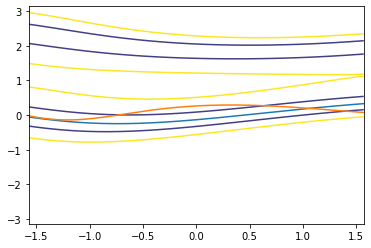

In [10]:
f_1= sp.lambdify((z[0], z[3]), abs(e[3])**2, 'numpy')
df_1 = sp.lambdify((z[0], z[3]), DF[0], 'numpy')
plt.figure(0)
plt.contour(t2, t1, f_1(np.exp(1j*t1),np.exp(1j*t2)), [0,  0.1,  0.535])

for i in range(401):
    f = lambda x: f_1(np.exp(1j*x), np.exp(1j*pwm[i]))
    res = spo.minimize_scalar(f, bounds=(-1, 1))
    leg_angles[i,0] = res.x
    leg_grad[i, 0] = np.real(df_1(np.exp(1j*res.x), np.exp(1j*pwm[i])))
    
plt.plot(pwm, leg_angles[:, 0])
plt.plot(pwm, leg_grad[:, 0])
plt.show()

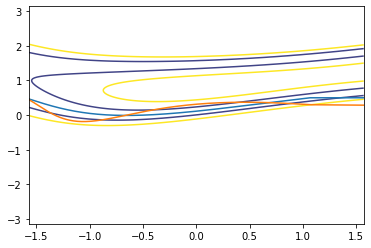

In [11]:
f_2 = sp.lambdify((z[1], z[4]), abs(e[4])**2, 'numpy')
df_2 = sp.lambdify((z[1], z[4]), DF[1], 'numpy')
plt.figure(1)
plt.contour(t2,t1, f_2(np.exp(1j*t1),np.exp(1j*t2)), [0, 0.01, 0.05])

for i in range(401):
    f = lambda x:  1000*f_2(np.exp(1j*x), np.exp(1j*pwm[i]))
    res = spo.minimize_scalar(f, bounds=(-1, 0.5), method='bounded')
    leg_angles[i,1] = res.x
    leg_grad[i, 1] = np.real(df_2(np.exp(1j*res.x), np.exp(1j*pwm[i])))

plt.plot(pwm, leg_angles[:, 1])
plt.plot(pwm, leg_grad[:, 1])
plt.show()

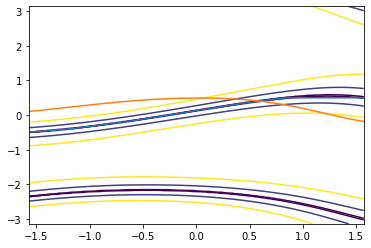

In [12]:
f_3 = sp.lambdify((z[2], z[5]), abs(e[5])**2, 'numpy')
df_3 = sp.lambdify((z[2], z[5]), DF[2], 'numpy')
plt.figure(2)
plt.contour(t2,t1, f_3(np.exp(1j*t1),np.exp(1j*t2)), [0, 0.001,  0.1,  0.535])

for i in range(401):
    f = lambda x:  f_3(np.exp(1j*x), np.exp(1j*pwm[i]))
    res = spo.minimize_scalar(f, bounds=(-1, 0.5), method='bounded')
    leg_angles[i,2] = res.x
    leg_grad[i,2] = np.real(df_3(np.exp(1j*res.x), np.exp(1j*pwm[i])))

plt.plot(pwm, leg_angles[:, 2])
plt.plot(pwm, leg_grad[:, 2])
plt.show()

In [13]:
# leg_angles now has the mapping between pwn and theta values
# now we can solve inverse kinematics directly.
# x = f(z) = f(z(u))
# so x_{n + 1} = x_n + v dt  = f(z) + D_zf * (Dz / Du) 
# solve: (u_{n+1}- u_n)/(z_{n+1} - z_n) = D_z[f(z)]^{-1} v dt

In [14]:
leg_pos = sp.lambdify((z[0], z[1], z[2]), np.real(e[0:3]))
leg_pos_jacobian = sp.lambdify(
    (z[0], z[1], z[2]), [[(1j * z_i * e_j.diff(z_i)).simplify() for z_i in z[0:3]] for e_j in e[0:3]]
)
def pwm_rad_to_index(pwm_value):
    if (pwm_value < pwm[0]) or (pwm_value > pwm[-1]):
        return None
    idx = (np.abs(pwm - pwm_value)).argmin()
    
    return idx
    

def forward_kinematics(pwm_0_rad, pwm_1_rad, pwm_2_rad):
    # i0 = pwm_rad_to_index(pwm_0_rad)
    i0 = (np.abs(pwm - pwm_0_rad)).argmin()
    i1 = (np.abs(pwm - pwm_1_rad)).argmin()
    i2 = (np.abs(pwm - pwm_2_rad)).argmin()
    z_0 = np.exp(1j*leg_angles[i0,0])
    z_1 = np.exp(1j*leg_angles[i1,1])
    z_2 = np.exp(1j*leg_angles[i2,2])
    
    return [np.real(x_i ) for x_i in leg_pos(z_0,z_1, z_2)]

def forward_differential_kinematics(pwm_0_rad, pwm_1_rad, pwm_2_rad):
    i0  = pwm_rad_to_index(pwm_0_rad)
    i1  = pwm_rad_to_index(pwm_1_rad)
    i2  = pwm_rad_to_index(pwm_2_rad)
    
    if any(i is None for i in [i0, i1, i2]):
        return None
    if any(leg_grad[i, idx] <= 0 for idx, i in enumerate([i0, i1, i2])):
        return None
    
    z_0 = np.exp(1j*leg_angles[i0,0])
    z_1 = np.exp(1j*leg_angles[i1,1])
    z_2 = np.exp(1j*leg_angles[i2,2])
    
    j_star = np.real(leg_pos_jacobian(z_0, z_1, z_2))
    d_star = np.diag([leg_grad[i, idx] for idx, i in enumerate([i1, i1, i2])])
    
    return j_star @ d_star

In [55]:
atoms, pos, _ = mdl.get_leg_position()
angles = atoms[0:3]
from sympy.utilities.codegen import codegen
eqs = []
subs = []
for i, th in enumerate(atoms[0:3]):
    s_i, c_i = sp.symbols(f"s_{i}, c_{i}")
    sin_i = sp.sin(th)
    cos_i = sp.cos(th)
    subs.append((sin_i, s_i))
    subs.append((cos_i, c_i))
    eqs.append(sp.Eq(s_i, sin_i))
    eqs.append(sp.Eq(c_i, cos_i))

P = [ p.subs(subs) for p in pos]

J = [[pos[i].diff(x_j).subs(subs) for x_j in angles] for i in range(3)]

P

[-15.0*c_1*s_0 + 75.0*c_1 - 32.0*c_2*s_0 - 75.0*s_0*s_1 - 66.0*s_0 - 15.0*s_1 - 32.0*s_2 + 42.0,
 15.0*c_0*c_1 + 32.0*c_0*c_2 + 75.0*c_0*s_1 + 66.0*c_0 + 75.0*c_1*s_0 - 15.0*s_0*s_1 - 32.0*s_0*s_2 + 42.0,
 -75.0*c_1 + 15.0*s_1 + 32.0*s_2]

Reached bounds


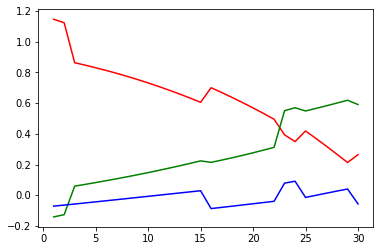

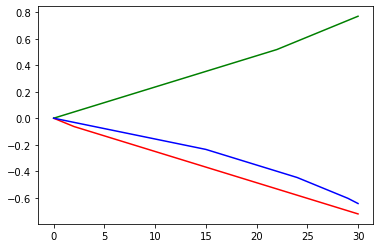

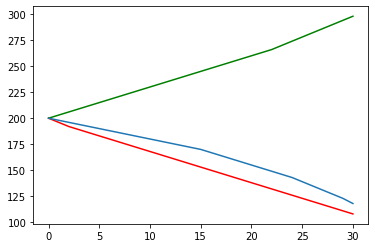

In [15]:
# target frequency: 100hz, dt = 1 /100
# target speed: 500 mm/s
# solve f(u[n+1]) - f(u[n])  = vdt
#       implies Df(u_n)(u_n+1 - u_n) = vdt
x_rest = np.array(forward_kinematics(0,0,0))
vdt = np.array([1, 0.0, 0.0])
N_max = 1000
N = 0
U = np.zeros(shape=(3, N_max), dtype=float)
IDX = np.zeros(shape=(3, N_max), dtype=int)
IDX[:,0] = [200,200,200]
X = np.empty_like(U)
X[:, 0] = x_rest

while N < (N_max - 2):
 
    Df_now = forward_differential_kinematics(*U[:, N].tolist())
    if Df_now is None or (abs(np.linalg.det(Df_now)) < 0.01):
        print("Reached bounds")
        break
    u_next = U[:, N] + np.linalg.inv(Df_now) @ vdt
    
    for i in range(3):
        idx = pwm_rad_to_index(u_next[i])
        IDX[i, N + 1] = idx
        U[i, N + 1] = pwm[idx]
    
    X[:, N + 1] = forward_kinematics(*U[:, N + 1].tolist())
    N += 1
    
f = plt.figure(4)
plt.plot(np.arange(1,N), X[0,1:N] -X[0, 0: N -1], 'r')
plt.plot(np.arange(1, N), X[1,1:N] -X[1, 0: N -1],'g')
plt.plot(np.arange(1, N), X[2,1:N] -X[2, 0: N -1],'b')

f = plt.figure(5)
plt.plot(np.arange(N), U[0,:N],'r')
plt.plot(np.arange(N), U[1,:N],'g')
plt.plot(np.arange(N), U[2,:N],'b')


f = plt.figure(6)
plt.plot(np.arange(N), IDX[0,:N],'r')
plt.plot(np.arange(N), IDX[1,:N],'g')
plt.plot(np.arange(N), IDX[2,:N])


In [16]:
def inverse_kinematics(x_desired, u_current=None, tolerance_mm=1, max_iters=100):
    # g = f(u) - x_desired
    # Dg = Df(u)
    # u_n+1 = u_n - Df(u_n)^{-1}[f(u_n) - x_desired]
    if u_current is None:
        u_current = np.array([0, 0, 0], dtype=float)

    tol_sqr= tolerance_mm**2
    
    for iters in range(max_iters):
        g = forward_kinematics(*u_current.tolist()) - x_desired
        if g.T @ g < tol_sqr:
            return u_current
        
        Dg = forward_differential_kinematics(*u_current.tolist())
        if Dg is None or abs(np.linalg.det(Dg)) < 1:
            break
        
        # replace with:  solve Dg u_next = Dg @ current - g  
        # Dg = L @ D @ U -. U(u_+ - u_-) = D^{-1} L^{-1} 
        # x = u_next - u_current  
        # u_next = x + b
        u_current -= np.linalg.inv(Dg) @ g 
        
    return None # failed to congerge


In [17]:
# footstep planner
# support n_gons = a_1x_1 + a_2x_2 + a_3x_3 + a_4x_4 = 0 




## Footstep planning
1. find the three legs supporting the center of mass - three placed legs, or one with largest area
2. work out how long until the com leaves the suppot polygon (or the leg hits bounds) at the current speed
3. work out where to place the spare leg at the switch point 
4. pick the next 'worst' leg.

In [18]:
from scipy.linalg import lu
Xn = np.empty(shape=(12,), dtype=float)
Xn[0:3] = x_rest
Xn[3:6] = x_rest
Xn[3] = -Xn[3] + 10
Xn[6:9] = x_rest
Xn[7] = -Xn[7]
Xn[9:12] = x_rest
Xn[9:11] = - Xn[9:11]




In [19]:
def closest_point_to_origin(x_0, x_1):
    r = x_1 - x_0
    t = - x_0.T @ r / (r @ r)
    if t <= 0:
        return x_0
    if t >= 1:
        return x_0
    return x_0*(1-t) + x_1 * t

In [20]:
# reset curve: x(s) =  [ l*(x_reset, y_reset) + (1-l)(x_lift, y_lift), h - l(1-l)h_max
# stroke curve: x(s) = x(s - ds) + dt*(v + \omega e_z \cross x(s)), z = 0
# for l = (s - s_t)/(1 - s_t)
# given x_now
e_z = np.array([0,0,1], dtype=float)
L_z = np.array([[0,1,0],[-1,0,0],[0,0,1]])
class Walk:
    def __init__(self,  dx, dy, omega=0, stance_height=0):
        self.x_rest = np.array([x_rest[0], x_rest[1], x_rest[2] + stance_height] )
        self.u_rest = inverse_kinematics(self.x_rest)
        self.dx = dx
        self.dy = dy
        self.s_reset = 0
        self.omega = omega
        self.x0 = np.empty_like(self.x_rest)
        self.x1 = np.empty_like(self.x_rest)
        self._find_extent()
        
    def _find_extent(self):
        t_start = 0
        t_final = 0
        dt = 0.1
        x_next = self.x_rest 
        while (True):
            x = x_next + dt *np.array([self.dx - self.omega * x_next[1], self.dy + self.omega * x_next[0], 0], dtype=float)
            u = inverse_kinematics(x)
            if u is None:
                break
            t_final += dt
            x_next = x
        self.x1[:] = x_next[:]
        x_next = self.x_rest 
        while (True):
            x = x_next - dt *np.array([self.dx - self.omega * x_next[1], self.dy + self.omega*x_next[0], 0], dtype=float)
            u = inverse_kinematics(x)
            if u is None:
                break
            t_start += dt
            x_next = x
        self.x0[:] = x_next[:]
        
        self.t_sweep = t_start + t_final
        self.t_reset = 1
        self.t_cycle = t_start + t_final + 1
        
    
    def reset(x_start, x_finish, height, t, t_max):
        
    
    def position(self, t):
        s = np.mod(t, self.t_cycle) 
        
        if s > self.t_sweep:
            l = (s - self.t_sweep)/ self.t_reset
            return self.x0 * l + self.x1 * (1 - l) + 20*(1 - l) * l * e_z
        v = np.array([self.dx, self.dy, 0])
        
        p = self.x0 + s * v
        if self.omega != 0:
            c1 = (1 - np.cos(self.omega * s))/self.omega
            s1 = np.sin(self.omega* s) / self.omega
            p += c1 * L_z @ v + (s - s1) * L_z @ L_z @ v
        return p
        
        
        
    

w.x0
w.x1

IndentationError: expected an indented block (<ipython-input-20-3e2b9e46b5e4>, line 50)

In [ ]:
# plot x(s), u(s)

In [ ]:
w = Walk(2, 0, 0)        
T = np.linspace(0, w.t_cycle, 100)
X = np.empty(shape=(100, 3))
for i, t in enumerate(T):
    X[i, :] = w.position(t) - x_rest

f = plt.figure(6)
plt.plot(T, X)

In [89]:
500-238

262

In [60]:
eqn = sp.Matrix(J).det()
eqn.as_coeff_add()

(0,
 (15360.0*c_0**2*c_2**2*s_1,
  15360.0*c_2**2*s_0**2*s_1,
  31680.0*c_0**2*c_2*s_1,
  31680.0*c_2*s_0**2*s_1,
  36000.0*c_0**2*c_2*s_1**2,
  36000.0*c_2*s_0**2*s_1**2,
  -76800.0*c_0**2*c_1*c_2**2,
  -76800.0*c_1*c_2**2*s_0**2,
  -7200.0*c_0**2*c_1**2*s_2,
  -7200.0*c_1**2*s_0**2*s_2,
  -31680.0*c_0**2*c_1*s_2,
  -31680.0*c_1*s_0**2*s_2,
  -36000.0*c_0**2*c_1**2*c_2,
  -36000.0*c_1**2*c_2*s_0**2,
  -158400.0*c_0**2*c_1*c_2,
  -158400.0*c_1*c_2*s_0**2,
  -158400.0*c_0**2*s_1*s_2,
  -158400.0*s_0**2*s_1*s_2,
  -180000.0*c_0**2*s_1**2*s_2,
  -180000.0*s_0**2*s_1**2*s_2,
  7200.0*c_0*c_2*s_0*s_1**2,
  36000.0*c_0*c_1**2*s_0*s_2,
  180000.0*c_0*c_1**2*c_2*s_0,
  -15360.0*c_0*c_1*s_0*s_2**2,
  -15360.0*c_0**2*c_1*c_2*s_2,
  -15360.0*c_1*c_2*s_0**2*s_2,
  -76800.0*c_0*s_0*s_1*s_2**2,
  -76800.0*c_0**2*c_2*s_1*s_2,
  -76800.0*c_2*s_0**2*s_1*s_2,
  -172800.0*c_0**2*c_1*c_2*s_1,
  -172800.0*c_1*c_2*s_0**2*s_1,
  -36000.0*c_0*s_0*s_1**2*s_2,
  -72000.0*c_0**2*c_1*s_1*s_2,
  -72000.0*c_1*s_0**

In [63]:
S = [s for s in eqn.atoms() if s.is_symbol]

In [73]:
sp.factor_list(eqn)

(-180000.000000000,
 [(1.0*c_1*c_2 + 0.2*c_1*s_2 - 0.2*c_2*s_1 + 1.0*s_1*s_2, 1),
  (0.2*c_0**2*c_1 + 0.426666666666667*c_0**2*c_2 + 1.0*c_0**2*s_1 + 0.88*c_0**2 - 1.0*c_0*c_1*s_0 + 0.2*c_0*s_0*s_1 + 0.426666666666667*c_0*s_0*s_2 + 0.2*c_1*s_0**2 + 0.426666666666667*c_2*s_0**2 + 1.0*s_0**2*s_1 + 0.88*s_0**2,
   1)])

In [84]:
eqn1 = eqn - eqn.coeff(S[0],0)

In [87]:
eqn1.coeff(S[0],0)

0